In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling
from businessscoring import businessgain

In [2]:
from Feature_Engineering import feature_engineering

In [5]:
features = feature_engineering(j_flag=0) # For the full dataset

In [6]:
features.shape

(5410, 39)

In [7]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
#features.set_index('Provider', inplace=True)

In [8]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider'], axis=1)
y = features['PotentialFraud'] 

In [9]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Both_Service', 'Inpatient', 'Outpatient',\
            'isFraudConnected']]

#drop dummy variables
X = X.drop(['Both_Service', 'Inpatient', 'Outpatient',\
           'isFraudConnected'], axis =1)

In [10]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled.head()

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,NetworkDegree,NoPhysicianCount
0,0.470588,-0.017544,-0.155665,-0.086957,-0.184866,1.142857,-0.114286,1.833333,-1.833333,-0.081081,...,-0.098592,-0.104712,-0.072222,-0.108844,-0.124113,-0.068063,-0.082474,-0.109714,0.333333,0.0
1,2.235294,1.614035,0.031527,1.443478,0.030651,13.857143,0.714286,3.833333,-3.833333,1.783784,...,1.530516,1.460733,1.466667,1.367347,1.308511,1.565445,1.448454,1.444571,0.000000,0.0
2,1.882353,1.982456,0.222660,1.582609,0.143678,0.000000,1.790476,0.000000,0.000000,1.756757,...,1.615023,1.649215,1.577778,1.591837,1.656028,1.554974,1.572165,1.572571,0.666667,0.0
3,0.000000,8.245614,15.763547,13.034783,24.233716,0.000000,14.333333,0.000000,0.000000,9.945946,...,12.990610,13.759162,13.233333,13.278912,13.081560,13.329843,13.257732,12.978286,-0.333333,2.0
4,0.235294,0.578947,0.650246,0.530435,0.593870,0.857143,0.580952,0.500000,-0.500000,0.567568,...,0.511737,0.591623,0.527778,0.544218,0.556738,0.539267,0.530928,0.489143,1.333333,0.0


In [11]:
#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head(5)

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,NetworkDegree,NoPhysicianCount,Both_Service,Inpatient,Outpatient,isFraudConnected
0,0.470588,-0.017544,-0.155665,-0.086957,-0.184866,1.142857,-0.114286,1.833333,-1.833333,-0.081081,...,-0.124113,-0.068063,-0.082474,-0.109714,0.333333,0.0,1,0,0,0.0
1,2.235294,1.614035,0.031527,1.443478,0.030651,13.857143,0.714286,3.833333,-3.833333,1.783784,...,1.308511,1.565445,1.448454,1.444571,0.000000,0.0,1,0,0,1.0
2,1.882353,1.982456,0.222660,1.582609,0.143678,0.000000,1.790476,0.000000,0.000000,1.756757,...,1.656028,1.554974,1.572165,1.572571,0.666667,0.0,0,0,1,0.0
3,0.000000,8.245614,15.763547,13.034783,24.233716,0.000000,14.333333,0.000000,0.000000,9.945946,...,13.081560,13.329843,13.257732,12.978286,-0.333333,2.0,0,0,1,0.0
4,0.235294,0.578947,0.650246,0.530435,0.593870,0.857143,0.580952,0.500000,-0.500000,0.567568,...,0.556738,0.539267,0.530928,0.489143,1.333333,0.0,1,0,0,0.0


In [12]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    3923
0    3923
Name: PotentialFraud, dtype: int64

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

### Examining VIF

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_Bal.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [round(variance_inflation_factor(X_train_Bal.values, i),3)
                          for i in range(len(X_train_Bal.columns))] 
  
print(vif_data)

/home/annie/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                            feature          VIF
0                        Phys_Count        3.378
1                     Patient_Count          inf
2                Norm_Patient_Count       34.277
3                       Claim_Count          inf
4                  Norm_Claim_Count       37.364
5                   Inpatient_Count          inf
6                  Outpatient_Count          inf
7              Norm_Inpatient_Count  7929424.928
8             Norm_Outpatient_Count  7929328.757
9                   DuplicateClaims       27.190
10         Duplicate_Claims_Percent        1.218
11                 AvgClaimDuration        2.422
12                         Avg_Cost        6.911
13                          Avg_Age        1.014
14                          Gender1          inf
15                          Gender2          inf
16                            Race1          inf
17                            Race2          inf
18                            Race3          inf
19                  

### Examining Correlation Matrix

In [16]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
plt.style.use('ggplot')

#### SMOTE balanced data

In [18]:
# SMOTE balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("SMOTE; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

SMOTE; 
Logistic Regression Baseline recall score:  0.9207920792079208


In [19]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring='recall', n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 939 ms, sys: 150 ms, total: 1.09 s
Wall time: 7.83 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='recall')

In [21]:
#SMOTE
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
SMOTE_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 1.5}
Logistic Regression Grid Search train recall score:  0.9630417262446379
Logistic Best Estimator Validation set recall score:  0.900990099009901
Logistic Best Estimator Validation set business score:  0.7676449259275704


#### imblearn balanced dataset

In [22]:
# imblearn balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_ros, y_ros)
logistic.score(X_test, y_test)
print("Random oversampling; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

Random oversampling; 
Logistic Regression Baseline recall score:  0.9504950495049505


In [23]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring='recall', n_jobs=-1)
%time grid_search_logit.fit(X_ros, y_ros)

CPU times: user 360 ms, sys: 14.2 ms, total: 374 ms
Wall time: 4.31 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='recall')

In [24]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
imblearn_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 1.4210526315789473}
Logistic Regression Grid Search train recall score:  0.9378061224489798
Logistic Best Estimator Validation set recall score:  0.9504950495049505
Logistic Best Estimator Validation set business score:  0.8595509775192766


#### Comparing SMOTE and imblearn

In [25]:
print('SMOTE logit business score: ', SMOTE_logit, '\nimblearn logit business score: ', imblearn_logit)

SMOTE logit business score:  0.7676449259275704 
imblearn logit business score:  0.8595509775192766


#### feature importance for logistic regression

,Feature,Score
35,isFraudConnected,14.418373
30,NetworkDegree,4.191582
23,ChronicCond_ObstrPulmonary,2.614368
34,Outpatient,1.895575
3,Claim_Count,1.668450
6,Outpatient_Count,1.629998
27,ChronicCond_Osteoporasis,1.629364
21,ChronicCond_KidneyDisease,1.512859
24,ChronicCond_Depression,1.300342
25,ChronicCond_Diabetes,1.228697


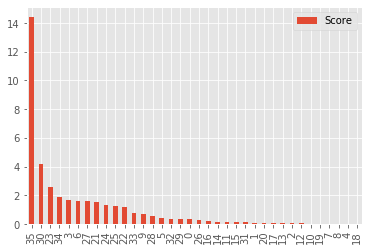

In [26]:
importance = logit_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent Classifier

In [27]:
from sklearn.linear_model import SGDClassifier

#### SMOTE

In [28]:
# SMOTE
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

SMOTE: 
SGD Baseline recall score:  0.9900990099009901


In [29]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring='recall', n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.12 s, sys: 58.1 ms, total: 2.18 s
Wall time: 10.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='recall')

In [31]:
print("SMOTE: \n")
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
SMOTE_sgd = businessgain(y_test,sgd_final.predict(X_test))

SMOTE: 

SGD Grid Search best params:  {'alpha': 0.0001275862068965517, 'max_iter': 100}
SGD Grid Search Training set recall score:  0.9867463928246458
SGD Best Estimator Validation set recall score:  0.9900990099009901
SGD Best Estimator Validation set business score:  0.7469549645547514


#### imblearn balanced

In [32]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_ros, y_ros)
print("Imblearn Balanced: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

Imblearn Balanced: 
SGD Baseline recall score:  0.9900990099009901


In [33]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring='recall', n_jobs=-1)
%time grid_search_sgd.fit(X_ros, y_ros)

CPU times: user 2.19 s, sys: 32.9 ms, total: 2.22 s
Wall time: 9.97 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='recall')

In [34]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
imblearn_sgd = businessgain(y_test,sgd_final.predict(X_test))

SGD Grid Search best params:  {'alpha': 0.00011379310344827582, 'max_iter': 100}
SGD Grid Search Training set recall score:  0.9895499155076042
SGD Best Estimator Validation set recall score:  0.9900990099009901
SGD Best Estimator Validation set business score:  0.7220914916603768


#### Comparing SMOTE with imblearn

In [35]:
print('SMOTE SGD business score: ', SMOTE_sgd, '\nimblearn SGD business score: ', imblearn_sgd)

SMOTE SGD business score:  0.7469549645547514 
imblearn SGD business score:  0.7220914916603768


#### SGD feature Importance

,Feature,Score
35,isFraudConnected,56.708068
32,Both_Service,35.750333
34,Outpatient,27.652641
30,NetworkDegree,11.791302
33,Inpatient,11.093471
6,Outpatient_Count,6.867534
31,NoPhysicianCount,5.382220
8,Norm_Outpatient_Count,4.370464
7,Norm_Inpatient_Count,4.370464
10,Duplicate_Claims_Percent,4.073435


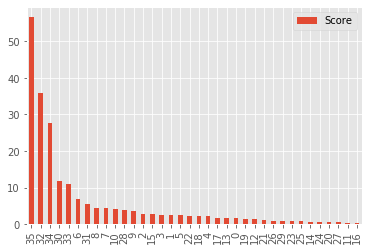

In [36]:
importance = sgd_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### K-Nearest Neighbors

#### SMOTE

In [37]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nKNN Baseline Training Set recall score: ", recall_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set recall score:  0.9971960234514402
KNN Baseline Validation Set recall score:  0.9108910891089109


In [38]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'recall')

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='recall', verbose=1)

In [39]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
SMOTE_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 77}
KNN Grid Search Training set Recall score:  0.9441753759877645
KNN Grid Search Validation set Recall score:  0.9504950495049505
KNN Grid Search Validation set business score:  0.6997143660554396


#### imblearn

In [41]:
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
print("imblearn: \nKNN Baseline Training Set recall score: ", recall_score(y_ros,knn.predict(X_ros)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

imblearn: 
KNN Baseline Training Set recall score:  1.0
KNN Baseline Validation Set recall score:  0.8118811881188119


In [42]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'recall')

knn_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='recall', verbose=1)

In [43]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_ros, best_knn.predict(X_ros)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
imblearn_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 77}
KNN Grid Search Training set Recall score:  0.9084884017333673
KNN Grid Search Validation set Recall score:  0.9306930693069307
KNN Grid Search Validation set business score:  0.6731341295564534


#### Comparing SMOTE and imblearn

In [44]:
print('SMOTE KNN business score: ', SMOTE_knn, '\nimblearn KNN business score: ', imblearn_knn)

SMOTE KNN business score:  0.6997143660554396 
imblearn KNN business score:  0.6731341295564534


In [27]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[159,  52],
       [  9,  49]])

### Support Vector Machine

#### SMOTE

In [45]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

SVC(class_weight='balanced')

In [46]:
# baseline score
svm_train_recall = recall_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('SMOTE: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

SMOTE: 
SVM BaseLine Train Set Recall Score: 0.9645679327045629
SVM BaseLine Validation Set Recall Score: 0.9108910891089109


In [47]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'recall')
svm_GS.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring='recall', verbose=1)

In [48]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
SMOTE_svm = businessgain(y_test, best_svm.predict(X_test))

SVM Grid Search Best params:  {'C': 0.21544346900318834, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  0.9831761407086413
SVM Grid Search Validation set Recall score:  0.9603960396039604
Test Set business Score: 0.7491157187467625


#### imblearn

In [49]:
svm = SVC(class_weight='balanced')
svm.fit(X_ros, y_ros)

SVC(class_weight='balanced')

In [50]:
# baseline score
svm_train_recall = recall_score(y_ros, svm.predict(X_ros))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('imblearn: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

imblearn: 
SVM BaseLine Train Set Recall Score: 0.9217435635992862
SVM BaseLine Validation Set Recall Score: 0.9405940594059405


In [51]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'recall')
svm_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring='recall', verbose=1)

In [52]:
print("imblearn: \nSVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_ros, best_svm.predict(X_ros)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
imblearn_svm = businessgain(y_test, best_svm.predict(X_test))

imblearn: 
SVM Grid Search Best params:  {'C': 100.0, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  1.0
SVM Grid Search Validation set Recall score:  0.5247524752475248
Test Set business Score: -0.03218931758646717


#### Comparing SMOTE and imblearn

In [53]:
print('SMOTE svm business score: ', SMOTE_svm, '\nimblearn svm business score: ', imblearn_svm)

SMOTE svm business score:  0.7491157187467625 
imblearn svm business score:  -0.03218931758646717


In [54]:
#recall = TP / (TP+FN) 
confusion_matrix(y_test, best_svm.predict(X_test))

array([[960,  21],
       [ 48,  53]])

### Discriminant Analysis

#### SMOTE

In [55]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train_Bal, y_train_Bal)

LinearDiscriminantAnalysis()

In [56]:
y_predict = LDA.predict(X_test)
print("SMOTE: \nLDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("LDA Baseline validation set business score: ", businessgain(y_test,y_predict))

SMOTE: 
LDA Baseline validation set recall score:  0.8316831683168316
LDA Baseline validation set business score:  0.6337669641403603


In [57]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X_train_Bal, y_train_Bal)
y_predict = QDA.predict(X_test)

print("QDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("QDA Baseline validation set business score: ", businessgain(y_test,y_predict))


QDA Baseline validation set recall score:  0.8811881188118812
QDA Baseline validation set business score:  0.7173851914339416


/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Random Forest

In [58]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set Recall Score:', recall_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.9108910891089109


In [60]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 11.4 s, sys: 375 ms, total: 11.8 s
Wall time: 7min 13s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='recall')

In [61]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 90}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.9108910891089109
RF Grid Search Validation set Business score:  0.8016546049223756


#### imblearn

In [62]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set Recall Score:', recall_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.8811881188118812


In [63]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 10 s, sys: 267 ms, total: 10.3 s
Wall time: 4min 2s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='recall')

In [64]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.9207920792079208
RF Grid Search Validation set Business score:  0.8155367106217348


#### comparing SMOTE and imblearn

In [65]:
print('SMOTE rf business score: ', SMOTE_rf, '\nimblearn rf business score: ', imblearn_rf)

SMOTE rf business score:  0.8016546049223756 
imblearn rf business score:  0.8155367106217348


### XG BOOST 

In [20]:
from xgboost import XGBClassifier

#SMOTE
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
print('SMOTE: \nXGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

SMOTE: 
XGB BaseLine Train Set Recall Score: 0.99974509304104
XGB BaseLine Validation Set Recall Score: 0.9207920792079208


In [23]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 } 

In [28]:
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 1.37 s, sys: 37.4 ms, total: 1.41 s
Wall time: 10.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree

In [29]:
grid_search_xgb.best_params_

{'learning_rate': 0.001,
 'max_depth': 1,
 'n_estimators': 2,
 'scale_pos_weight': 400,
 'subsample': 0.9}

In [30]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
SMOTE_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 1.0
XGB BaseLine Validation Set business Score: -0.12596012964525152


#### imblearn

In [31]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_ros, y_ros)
print('imblearn: \nXGB BaseLine Train Set Recall Score:', recall_score(y_ros, xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

imblearn: 
XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9207920792079208


In [33]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 }
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_ros, y_ros)

CPU times: user 1.03 s, sys: 24.3 ms, total: 1.05 s
Wall time: 7.69 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree

In [34]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_ros, best_xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
imblearn_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 1.0
XGB BaseLine Validation Set business Score: -0.07741715875623437


#### comparing SMOTE and imblearn

In [35]:
print('SMOTE xgb business score: ', SMOTE_xgb, '\nimblearn xgb business score: ', imblearn_xgb)

SMOTE xgb business score:  -0.12596012964525152 
imblearn xgb business score:  -0.07741715875623437


In [36]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[ 71, 910],
       [  0, 101]])

## Unsupervised Learning

### Principal Component Analysis

In [45]:
from sklearn.decomposition import PCA
pca = PCA()
pca.set_params(n_components=3)

PCA(n_components=3)

In [46]:
pca.set_params(n_components=22).fit(X_train_Bal)
x_train2 = pca.transform(X_train_Bal)
x_test2 = pca.transform(X_test) # transformation

In [47]:
import sklearn.linear_model as lm
logit = lm.LogisticRegression()
logit.fit(x_train2, y_train_Bal)
print("PCA Logistic Regression Train recall score: ", recall_score(y_train_Bal,logit.predict(x_train2)))
print("PCA Logistic Regression Validation recall score: ", recall_score(y_test,logit.predict(x_test2)))
print("PCA Logistic Regression Validation business score: ", businessgain(y_test,logit.predict(x_test2)))

PCA Logistic Regression Train recall score:  0.9655172413793104
PCA Logistic Regression Validation recall score:  0.8793103448275862
PCA Logistic Regression Validation business score:  0.7359414463172002
